# NSMC 감성분석

## 1. 일반적인 LSTM방식

In [1]:
import pandas as pd
import urllib.request
%matplotlib inline
import matplotlib.pyplot as plt
import re
from konlpy.tag import Okt
from tensorflow import keras
from tensorflow.keras.preprocessing.text import Tokenizer
import numpy as np
from tensorflow.keras.preprocessing.sequence import pad_sequences
from collections import Counter

# 데이터를 읽어봅시다. 
train_data = pd.read_table('~/aiffel/sentiment_classification/ratings_train.txt')
test_data = pd.read_table('~/aiffel/sentiment_classification/ratings_test.txt')

train_data.head()

,id,document,label
0,9976970,아 더빙.. 진짜 짜증나네요 목소리,0
1,3819312,흠...포스터보고 초딩영화줄....오버연기조차 가볍지 않구나,1
2,10265843,너무재밓었다그래서보는것을추천한다,0
3,9045019,교도소 이야기구먼 ..솔직히 재미는 없다..평점 조정,0
4,6483659,사이몬페그의 익살스런 연기가 돋보였던 영화!스파이더맨에서 늙어보이기만 했던 커스틴 ...,1


In [2]:
from konlpy.tag import Mecab
tokenizer = Mecab()
stopwords = ['의','가','이','은','들','는','좀','잘','걍','과','도','를','으로','자','에','와','한','하다']

def load_data(train_data, test_data, num_words=10000):
    train_data.drop_duplicates(subset=['document'], inplace=True)
    train_data = train_data.dropna(how = 'any') 
    test_data.drop_duplicates(subset=['document'], inplace=True)
    test_data = test_data.dropna(how = 'any') 

    X_train = []
    for sentence in train_data['document']:
        temp_X = tokenizer.morphs(sentence) # 토큰화
        temp_X = [word for word in temp_X if not word in stopwords] # 불용어 제거
        X_train.append(temp_X)

    X_test = []
    for sentence in test_data['document']:
        temp_X = tokenizer.morphs(sentence) # 토큰화
        temp_X = [word for word in temp_X if not word in stopwords] # 불용어 제거
        X_test.append(temp_X)

    words = np.concatenate(X_train).tolist()
    counter = Counter(words)
    counter = counter.most_common(10000-4)
    vocab = ['<PAD>', '<BOS>', '<UNK>', '<UNUSED>'] + [key for key, _ in counter]
    word_to_index = {word:index for index, word in enumerate(vocab)}

    def wordlist_to_indexlist(wordlist):
        return [word_to_index[word] if word in word_to_index else word_to_index['<UNK>'] for word in wordlist]

    X_train = list(map(wordlist_to_indexlist, X_train))
    X_test = list(map(wordlist_to_indexlist, X_test))

    return X_train, np.array(list(train_data['label'])), X_test, np.array(list(test_data['label'])), word_to_index

X_train, y_train, X_test, y_test, word_to_index = load_data(train_data, test_data)

In [3]:
index_to_word = {index:word for word, index in word_to_index.items()}

In [4]:
# 문장 1개를 활용할 딕셔너리와 함께 주면, 단어 인덱스 리스트 벡터로 변환해 주는 함수입니다. 
# 단, 모든 문장은 <BOS>로 시작하는 것으로 합니다. 
def get_encoded_sentence(sentence, word_to_index):
    return [word_to_index['<BOS>']]+[word_to_index[word] if word in word_to_index else word_to_index['<UNK>'] for word in sentence.split()]

# 여러 개의 문장 리스트를 한꺼번에 단어 인덱스 리스트 벡터로 encode해 주는 함수입니다. 
def get_encoded_sentences(sentences, word_to_index):
    return [get_encoded_sentence(sentence, word_to_index) for sentence in sentences]

# 숫자 벡터로 encode된 문장을 원래대로 decode하는 함수입니다. 
def get_decoded_sentence(encoded_sentence, index_to_word):
    return ' '.join(index_to_word[index] if index in index_to_word else '<UNK>' for index in encoded_sentence[1:])  #[1:]를 통해 <BOS>를 제외

# 여러개의 숫자 벡터로 encode된 문장을 한꺼번에 원래대로 decode하는 함수입니다. 
def get_decoded_sentences(encoded_sentences, index_to_word):
    return [get_decoded_sentence(encoded_sentence, index_to_word) for encoded_sentence in encoded_sentences]

In [5]:
total_data_text = list(X_train) + list(X_test)
# 텍스트데이터 문장길이의 리스트를 생성한 후
num_tokens = [len(tokens) for tokens in total_data_text]
num_tokens = np.array(num_tokens)
# 문장길이의 평균값, 최대값, 표준편차를 계산해 본다. 
print('문장길이 평균 : ', np.mean(num_tokens))
print('문장길이 최대 : ', np.max(num_tokens))
print('문장길이 표준편차 : ', np.std(num_tokens))

max_tokens = np.mean(num_tokens) + 2 * np.std(num_tokens)
maxlen = int(max_tokens)
print('pad_sequences maxlen : ', maxlen)
print('전체 문장의 {}%가 maxlen 설정값 이내에 포함됩니다. '.format(np.sum(num_tokens < max_tokens) / len(num_tokens)))

문장길이 평균 :  15.969355837799927
문장길이 최대 :  116
문장길이 표준편차 :  12.843536204665021
pad_sequences maxlen :  41
전체 문장의 0.9342988343341575%가 maxlen 설정값 이내에 포함됩니다. 


In [6]:
x_train = keras.preprocessing.sequence.pad_sequences(X_train,
                                                        value=word_to_index["<PAD>"],
                                                        padding='pre',
                                                        maxlen=maxlen)

x_test = keras.preprocessing.sequence.pad_sequences(X_test,
                                                       value=word_to_index["<PAD>"],
                                                       padding='pre',
                                                       maxlen=maxlen)

print(x_train.shape)

(146182, 41)


In [7]:
vocab_size = 10000   
word_vector_dim = 16 


model = keras.Sequential()
model.add(keras.layers.Embedding(vocab_size, word_vector_dim, input_shape=(None,)))
model.add(keras.layers.LSTM(8))  
model.add(keras.layers.Dense(8, activation='relu'))
model.add(keras.layers.Dense(1, activation='sigmoid'))


model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, None, 16)          160000    
_________________________________________________________________
lstm (LSTM)                  (None, 8)                 800       
_________________________________________________________________
dense (Dense)                (None, 8)                 72        
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 9         
Total params: 160,881
Trainable params: 160,881
Non-trainable params: 0
_________________________________________________________________


In [8]:
x_val = x_train[:10000]   
y_val = y_train[:10000]


partial_x_train = x_train[10000:]  
partial_y_train = y_train[10000:]

print(partial_x_train.shape)
print(partial_y_train.shape)

(136182, 41)
(136182,)


In [9]:
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
              
epochs=6  # 몇 epoch를 훈련하면 좋을지 결과를 보면서 바꾸어 봅시다. 

history = model.fit(partial_x_train,
                    partial_y_train,
                    epochs=epochs,
                    batch_size=512,
                    validation_data=(x_val, y_val),
                    verbose=1)

Epoch 1/6
266/266 [==============================] - 1s 4ms/step - loss: 0.5224 - accuracy: 0.7562 - val_loss: 0.3759 - val_accuracy: 0.8432
Epoch 2/6
266/266 [==============================] - 1s 4ms/step - loss: 0.3458 - accuracy: 0.8548 - val_loss: 0.3411 - val_accuracy: 0.8526
Epoch 3/6
266/266 [==============================] - 1s 4ms/step - loss: 0.3184 - accuracy: 0.8662 - val_loss: 0.3407 - val_accuracy: 0.8525
Epoch 4/6
266/266 [==============================] - 1s 4ms/step - loss: 0.3056 - accuracy: 0.8719 - val_loss: 0.3398 - val_accuracy: 0.8524
Epoch 5/6
266/266 [==============================] - 1s 4ms/step - loss: 0.2951 - accuracy: 0.8767 - val_loss: 0.3440 - val_accuracy: 0.8542
Epoch 6/6
266/266 [==============================] - 1s 4ms/step - loss: 0.2845 - accuracy: 0.8829 - val_loss: 0.3408 - val_accuracy: 0.8561


In [10]:
results = model.evaluate(x_test,  y_test, verbose=2)

print(results)

1537/1537 - 2s - loss: 0.3560 - accuracy: 0.8466
[0.3560064435005188, 0.8465935587882996]


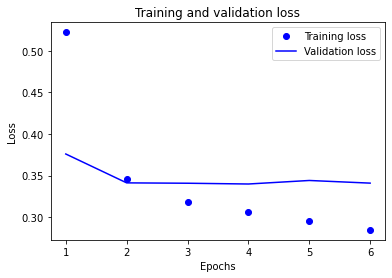

In [11]:
history_dict = history.history
import matplotlib.pyplot as plt

acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)

# "bo"는 "파란색 점"입니다
plt.plot(epochs, loss, 'bo', label='Training loss')
# b는 "파란 실선"입니다
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

성능이 가장 뒤떨어졌다... 다른 방식도 시도해 봐야 한다.

## 2. word2vec를 이용한 감성분석

In [12]:
embedding_layer = model.layers[0]
weights = embedding_layer.get_weights()[0]
print(weights.shape)    # shape: (vocab_size, embedding_dim)

(10000, 16)


In [13]:
import os
word2vec_path = os.getenv('HOME')+'/aiffel/sentiment_classification/ko/ko.bin'

In [14]:
import gensim
word2vec = gensim.models.Word2Vec.load(word2vec_path)


In [15]:
word2vec.similar_by_word("사랑")

/home/aiffel0038/anaconda3/envs/aiffel/lib/python3.7/site-packages/ipykernel_launcher.py:1: DeprecationWarning: Call to deprecated `similar_by_word` (Method will be removed in 4.0.0, use self.wv.similar_by_word() instead).
  """Entry point for launching an IPython kernel.


[('슬픔', 0.7216663360595703),
 ('행복', 0.6759077310562134),
 ('절망', 0.6468985676765442),
 ('기쁨', 0.6458414793014526),
 ('이별', 0.6334798336029053),
 ('추억', 0.6320937871932983),
 ('인생', 0.6216273307800293),
 ('애정', 0.6206068992614746),
 ('연인', 0.6186063289642334),
 ('유혹', 0.5965287685394287)]

In [16]:
vocab_size = 10000    
word_vector_dim = 200

embedding_matrix = np.random.rand(vocab_size, word_vector_dim)

# embedding_matrix에 Word2Vec 워드벡터를 단어 하나씩마다 차례차례 카피한다.
for i in range(4,vocab_size):
    if index_to_word[i] in word2vec:
        embedding_matrix[i] = word2vec[index_to_word[i]]

/home/aiffel0038/anaconda3/envs/aiffel/lib/python3.7/site-packages/ipykernel_launcher.py:8: DeprecationWarning: Call to deprecated `__contains__` (Method will be removed in 4.0.0, use self.wv.__contains__() instead).
  
/home/aiffel0038/anaconda3/envs/aiffel/lib/python3.7/site-packages/ipykernel_launcher.py:9: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  if __name__ == '__main__':


In [17]:
from tensorflow.keras.initializers import Constant

vocab_size = 10000    # 어휘 사전의 크기입니다(10,000개의 단어)
word_vector_dim = 200  # 워드 벡터의 차원수 (변경가능한 하이퍼파라미터)

# 모델 구성

    
model = keras.Sequential()
model.add(keras.layers.Embedding(vocab_size, 
                                 word_vector_dim, 
                                 embeddings_initializer=Constant(embedding_matrix),  # 카피한 임베딩을 여기서 활용
                                 input_length=maxlen, 
                                 trainable=True))   # trainable을 True로 주면 Fine-tuning
model.add(keras.layers.LSTM(32))
model.add(keras.layers.Dense(16, activation='relu'))
model.add(keras.layers.Dense(1, activation='sigmoid'))

model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 41, 200)           2000000   
_________________________________________________________________
lstm_1 (LSTM)                (None, 32)                29824     
_________________________________________________________________
dense_2 (Dense)              (None, 16)                528       
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 17        
Total params: 2,030,369
Trainable params: 2,030,369
Non-trainable params: 0
_________________________________________________________________


In [18]:
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
              
epochs= 5 # 몇 epoch를 훈련하면 좋을지 결과를 보면서 바꾸어 봅시다. 

history = model.fit(partial_x_train,
                    partial_y_train,
                    epochs=epochs,
                    batch_size=512,
                    validation_data=(x_val, y_val),
                    verbose=1)

Epoch 1/5
266/266 [==============================] - 6s 21ms/step - loss: 0.4680 - accuracy: 0.7712 - val_loss: 0.3713 - val_accuracy: 0.8339
Epoch 2/5
266/266 [==============================] - 5s 20ms/step - loss: 0.3395 - accuracy: 0.8523 - val_loss: 0.3333 - val_accuracy: 0.8579
Epoch 3/5
266/266 [==============================] - 5s 20ms/step - loss: 0.3001 - accuracy: 0.8739 - val_loss: 0.3218 - val_accuracy: 0.8583
Epoch 4/5
266/266 [==============================] - 5s 19ms/step - loss: 0.2760 - accuracy: 0.8867 - val_loss: 0.3353 - val_accuracy: 0.8580
Epoch 5/5
266/266 [==============================] - 5s 19ms/step - loss: 0.2573 - accuracy: 0.8947 - val_loss: 0.3332 - val_accuracy: 0.8592


In [19]:
results = model.evaluate(x_test,  y_test, verbose=2)

print(results)

1537/1537 - 2s - loss: 0.3452 - accuracy: 0.8542
[0.3452296853065491, 0.8542018532752991]


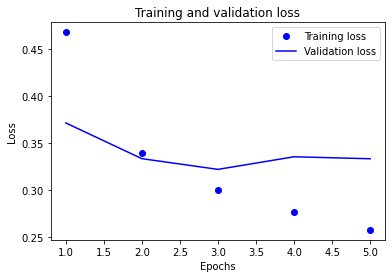

In [20]:
history_dict = history.history
import matplotlib.pyplot as plt

acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)

# "bo"는 "파란색 점"입니다
plt.plot(epochs, loss, 'bo', label='Training loss')
# b는 "파란 실선"입니다
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

1번 방식과 비교하면 정확도가 상승했다. word2vec의 효과라고 볼 수 있다.

### 2번방식에서 SpatialDropout을 넣은 방식

In [21]:
from tensorflow.keras.initializers import Constant

vocab_size = 10000    # 어휘 사전의 크기입니다(10,000개의 단어)
word_vector_dim = 200  # 워드 벡터의 차원수 (변경가능한 하이퍼파라미터)

# 모델 구성

    
model = keras.Sequential()
model.add(keras.layers.Embedding(vocab_size, 
                                 word_vector_dim, 
                                 embeddings_initializer=Constant(embedding_matrix),  # 카피한 임베딩을 여기서 활용
                                 input_length=maxlen, 
                                 trainable=True))   # trainable을 True로 주면 Fine-tuning
model.add(keras.layers.SpatialDropout1D(0.4))
model.add(keras.layers.LSTM(32))
model.add(keras.layers.Dense(16, activation='relu'))
model.add(keras.layers.Dense(1, activation='sigmoid'))

model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, 41, 200)           2000000   
_________________________________________________________________
spatial_dropout1d (SpatialDr (None, 41, 200)           0         
_________________________________________________________________
lstm_2 (LSTM)                (None, 32)                29824     
_________________________________________________________________
dense_4 (Dense)              (None, 16)                528       
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 17        
Total params: 2,030,369
Trainable params: 2,030,369
Non-trainable params: 0
_________________________________________________________________


In [22]:
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
              
epochs= 3 # 몇 epoch를 훈련하면 좋을지 결과를 보면서 바꾸어 봅시다. 

history = model.fit(partial_x_train,
                    partial_y_train,
                    epochs=epochs,
                    batch_size=32,
                    validation_data=(x_val, y_val),
                    verbose=1)

Epoch 1/3
4256/4256 [==============================] - 74s 17ms/step - loss: 0.4533 - accuracy: 0.7824 - val_loss: 0.3435 - val_accuracy: 0.8509
Epoch 2/3
4256/4256 [==============================] - 74s 17ms/step - loss: 0.3501 - accuracy: 0.8464 - val_loss: 0.3232 - val_accuracy: 0.8601
Epoch 3/3
4256/4256 [==============================] - 74s 17ms/step - loss: 0.3225 - accuracy: 0.8607 - val_loss: 0.3179 - val_accuracy: 0.8632


In [23]:
results = model.evaluate(x_test,  y_test, verbose=2)

print(results)

1537/1537 - 4s - loss: 0.3314 - accuracy: 0.8586
[0.3314104676246643, 0.8585755825042725]


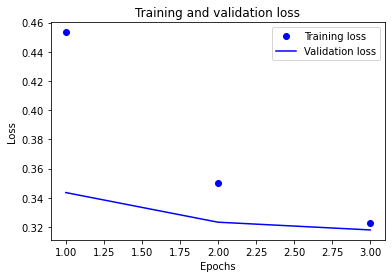

In [24]:
history_dict = history.history
import matplotlib.pyplot as plt

acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)

# "bo"는 "파란색 점"입니다
plt.plot(epochs, loss, 'bo', label='Training loss')
# b는 "파란 실선"입니다
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

Dropout을 추가하니 성능이 더욱 향상되었다. Dropout은 accuracy를 높이는 방식이라는 것을 다시금 깨닫게 했다.

### 위의 방식에서 LSTM을 2번 쓰고 Dropout한 방식

In [46]:
from tensorflow.keras.initializers import Constant

vocab_size = 10000    # 어휘 사전의 크기입니다(10,000개의 단어)
word_vector_dim = 200  # 워드 벡터의 차원수 (변경가능한 하이퍼파라미터)

# 모델 구성

    
model = keras.Sequential()
model.add(keras.layers.Embedding(vocab_size, 
                                 word_vector_dim, 
                                 embeddings_initializer=Constant(embedding_matrix),  # 카피한 임베딩을 여기서 활용
                                 input_length=maxlen, 
                                 trainable=True))   # trainable을 True로 주면 Fine-tuning
model.add(keras.layers.SpatialDropout1D(0.5))
model.add(keras.layers.LSTM(32,activation = 'relu',return_sequences = True))
model.add(keras.layers.LSTM(32))
model.add(keras.layers.Dropout(0.5))
model.add(keras.layers.Dense(16, activation='relu'))
model.add(keras.layers.Dense(1, activation='sigmoid'))

model.summary()

Model: "sequential_10"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_10 (Embedding)     (None, 41, 200)           2000000   
_________________________________________________________________
spatial_dropout1d_8 (Spatial (None, 41, 200)           0         
_________________________________________________________________
lstm_12 (LSTM)               (None, 41, 32)            29824     
_________________________________________________________________
lstm_13 (LSTM)               (None, 32)                8320      
_________________________________________________________________
dropout_7 (Dropout)          (None, 32)                0         
_________________________________________________________________
dense_22 (Dense)             (None, 16)                528       
_________________________________________________________________
dense_23 (Dense)             (None, 1)               

In [47]:
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
              
epochs= 5 # 몇 epoch를 훈련하면 좋을지 결과를 보면서 바꾸어 봅시다. 

history = model.fit(partial_x_train,
                    partial_y_train,
                    epochs=epochs,
                    batch_size=256,
                    validation_data=(x_val, y_val),
                    verbose=1)

Epoch 1/5
532/532 [==============================] - 27s 50ms/step - loss: 0.5684 - accuracy: 0.6975 - val_loss: 0.4254 - val_accuracy: 0.8047
Epoch 2/5
532/532 [==============================] - 26s 50ms/step - loss: 0.4314 - accuracy: 0.8029 - val_loss: 0.3490 - val_accuracy: 0.8450
Epoch 3/5
532/532 [==============================] - 26s 50ms/step - loss: 0.3751 - accuracy: 0.8340 - val_loss: 0.3260 - val_accuracy: 0.8574
Epoch 4/5
532/532 [==============================] - 26s 50ms/step - loss: 0.3500 - accuracy: 0.8469 - val_loss: 0.3172 - val_accuracy: 0.8615
Epoch 5/5
532/532 [==============================] - 27s 51ms/step - loss: 0.3327 - accuracy: 0.8563 - val_loss: 0.3132 - val_accuracy: 0.8643


In [48]:
results = model.evaluate(x_test,  y_test, verbose=2)

print(results)

1537/1537 - 7s - loss: 0.3229 - accuracy: 0.8606
[0.3229455351829529, 0.860630214214325]


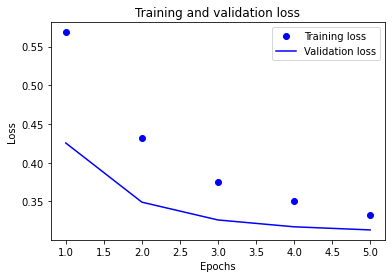

In [49]:
history_dict = history.history
import matplotlib.pyplot as plt

acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)

# "bo"는 "파란색 점"입니다
plt.plot(epochs, loss, 'bo', label='Training loss')
# b는 "파란 실선"입니다
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

LSTM을 2번 써주었더니 성능이 86%까지 올랐다. 이 노트북에는 없지만 3개 이상부터는 오히려 정확도를 떨어뜨린다.

### 위의 방식에서 Dropout과 LSTM의 순서를 바꾼 방식

In [42]:
from tensorflow.keras.initializers import Constant

vocab_size = 10000    # 어휘 사전의 크기입니다(10,000개의 단어)
word_vector_dim = 200  # 워드 벡터의 차원수 (변경가능한 하이퍼파라미터)

# 모델 구성

    
model = keras.Sequential()
model.add(keras.layers.Embedding(vocab_size, 
                                 word_vector_dim, 
                                 embeddings_initializer=Constant(embedding_matrix),  # 카피한 임베딩을 여기서 활용
                                 input_length=maxlen, 
                                 trainable=True))   # trainable을 True로 주면 Fine-tuning
model.add(keras.layers.SpatialDropout1D(0.5))
model.add(keras.layers.LSTM(32, return_sequences = True))
model.add(keras.layers.Dropout(0.5))
model.add(keras.layers.LSTM(16))
model.add(keras.layers.Dense(8, activation='relu'))
model.add(keras.layers.Dense(1, activation='sigmoid'))

model.summary()

Model: "sequential_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_9 (Embedding)      (None, 41, 200)           2000000   
_________________________________________________________________
spatial_dropout1d_7 (Spatial (None, 41, 200)           0         
_________________________________________________________________
lstm_10 (LSTM)               (None, 41, 32)            29824     
_________________________________________________________________
dropout_6 (Dropout)          (None, 41, 32)            0         
_________________________________________________________________
lstm_11 (LSTM)               (None, 16)                3136      
_________________________________________________________________
dense_20 (Dense)             (None, 8)                 136       
_________________________________________________________________
dense_21 (Dense)             (None, 1)                

In [43]:
model.compile(optimizer='rmsprop',
              loss='binary_crossentropy',
              metrics=['accuracy'])
              
epochs= 10 # 몇 epoch를 훈련하면 좋을지 결과를 보면서 바꾸어 봅시다. 

history = model.fit(partial_x_train,
                    partial_y_train,
                    epochs=epochs,
                    batch_size=32,
                    validation_data=(x_val, y_val),
                    verbose=1)

Epoch 1/10
4256/4256 [==============================] - 89s 21ms/step - loss: 0.5011 - accuracy: 0.7494 - val_loss: 0.3866 - val_accuracy: 0.8289
Epoch 2/10
4256/4256 [==============================] - 89s 21ms/step - loss: 0.3981 - accuracy: 0.8195 - val_loss: 0.3619 - val_accuracy: 0.8433
Epoch 3/10
4256/4256 [==============================] - 90s 21ms/step - loss: 0.3705 - accuracy: 0.8357 - val_loss: 0.3384 - val_accuracy: 0.8524
Epoch 4/10
4256/4256 [==============================] - 91s 21ms/step - loss: 0.3566 - accuracy: 0.8434 - val_loss: 0.3322 - val_accuracy: 0.8521
Epoch 5/10
4256/4256 [==============================] - 89s 21ms/step - loss: 0.3469 - accuracy: 0.8487 - val_loss: 0.3335 - val_accuracy: 0.8556
Epoch 6/10
4256/4256 [==============================] - 89s 21ms/step - loss: 0.3407 - accuracy: 0.8533 - val_loss: 0.3298 - val_accuracy: 0.8565
Epoch 7/10
4256/4256 [==============================] - 89s 21ms/step - loss: 0.3357 - accuracy: 0.8562 - val_loss: 0.3253 -

In [44]:
results = model.evaluate(x_test,  y_test, verbose=2)

print(results)

1537/1537 - 6s - loss: 0.3407 - accuracy: 0.8594
[0.34070420265197754, 0.8594096302986145]


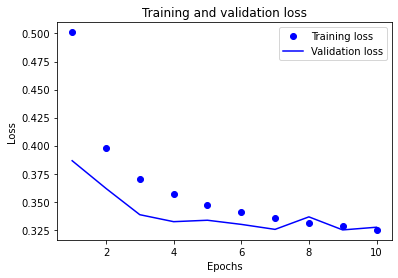

In [45]:
history_dict = history.history
import matplotlib.pyplot as plt

acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)

# "bo"는 "파란색 점"입니다
plt.plot(epochs, loss, 'bo', label='Training loss')
# b는 "파란 실선"입니다
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

Dropout과 LSTM의 순서를 바꿨지만 별 다른 효과가 없었다.

### FC레이어에 정규화를 넣어준 방식

In [21]:
from tensorflow.keras.initializers import Constant

vocab_size = 10000    # 어휘 사전의 크기입니다(10,000개의 단어)
word_vector_dim = 200  # 워드 벡터의 차원수 (변경가능한 하이퍼파라미터)

# 모델 구성

    
model = keras.Sequential()
model.add(keras.layers.Embedding(vocab_size, 
                                 word_vector_dim, 
                                 embeddings_initializer=Constant(embedding_matrix),  # 카피한 임베딩을 여기서 활용
                                 input_length=maxlen, 
                                 trainable=True))   # trainable을 True로 주면 Fine-tuning
model.add(keras.layers.SpatialDropout1D(0.5))
model.add(keras.layers.LSTM(32))
model.add(keras.layers.Dropout(0.5))
model.add(keras.layers.Dense(16, kernel_regularizer = keras.regularizers.l1_l2(0.001), activation = 'relu'))
model.add(keras.layers.Dense(8, kernel_regularizer = keras.regularizers.l1_l2(0.001),activation='relu'))
model.add(keras.layers.Dense(1, activation='sigmoid'))

model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, 41, 200)           2000000   
_________________________________________________________________
spatial_dropout1d (SpatialDr (None, 41, 200)           0         
_________________________________________________________________
lstm_2 (LSTM)                (None, 32)                29824     
_________________________________________________________________
dropout (Dropout)            (None, 32)                0         
_________________________________________________________________
dense_4 (Dense)              (None, 16)                528       
_________________________________________________________________
dense_5 (Dense)              (None, 8)                 136       
_________________________________________________________________
dense_6 (Dense)              (None, 1)                

In [22]:
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
              
epochs= 15 # 몇 epoch를 훈련하면 좋을지 결과를 보면서 바꾸어 봅시다. 

history = model.fit(partial_x_train,
                    partial_y_train,
                    epochs=epochs,
                    batch_size=512,
                    validation_data=(x_val, y_val),
                    verbose=1)

Epoch 1/15
266/266 [==============================] - 6s 21ms/step - loss: 0.8438 - accuracy: 0.6288 - val_loss: 0.5898 - val_accuracy: 0.7616
Epoch 2/15
266/266 [==============================] - 5s 20ms/step - loss: 0.5451 - accuracy: 0.7660 - val_loss: 0.4479 - val_accuracy: 0.8208
Epoch 3/15
266/266 [==============================] - 5s 20ms/step - loss: 0.4637 - accuracy: 0.8046 - val_loss: 0.4039 - val_accuracy: 0.8368
Epoch 4/15
266/266 [==============================] - 5s 20ms/step - loss: 0.4268 - accuracy: 0.8218 - val_loss: 0.3842 - val_accuracy: 0.8494
Epoch 5/15
266/266 [==============================] - 5s 20ms/step - loss: 0.4041 - accuracy: 0.8333 - val_loss: 0.3689 - val_accuracy: 0.8549
Epoch 6/15
266/266 [==============================] - 5s 20ms/step - loss: 0.3853 - accuracy: 0.8421 - val_loss: 0.3573 - val_accuracy: 0.8583
Epoch 7/15
266/266 [==============================] - 5s 20ms/step - loss: 0.3750 - accuracy: 0.8465 - val_loss: 0.3571 - val_accuracy: 0.8591

In [23]:
results = model.evaluate(x_test,  y_test, verbose=2)

print(results)

1537/1537 - 2s - loss: 0.3529 - accuracy: 0.8592
[0.35288527607917786, 0.8591858744621277]


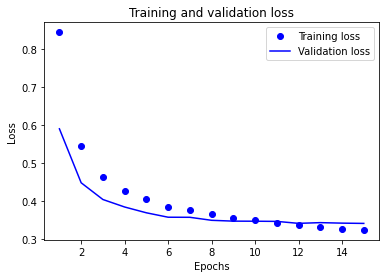

In [24]:
history_dict = history.history
import matplotlib.pyplot as plt

acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)

# "bo"는 "파란색 점"입니다
plt.plot(epochs, loss, 'bo', label='Training loss')
# b는 "파란 실선"입니다
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

정규화가 오히려 accuracy를 줄이는 효과를 갖는다. 일반화를 과도하게 한 문제라고 생각한다.

## LSTM에 Dropout을 거친다음 flatten한 방식

In [34]:
from tensorflow.keras.initializers import Constant

vocab_size = 10000    # 어휘 사전의 크기입니다(10,000개의 단어)
word_vector_dim = 200  # 워드 벡터의 차원수 (변경가능한 하이퍼파라미터)

# 모델 구성

    
model = keras.Sequential()
model.add(keras.layers.Embedding(vocab_size, 
                                 word_vector_dim, 
                                 embeddings_initializer=Constant(embedding_matrix),  # 카피한 임베딩을 여기서 활용
                                 input_length=maxlen, 
                                 trainable=True))

model.add(keras.layers.LSTM(32, return_sequences = True))
model.add(keras.layers.SpatialDropout1D(0.4))
model.add(keras.layers.Flatten())
model.add(keras.layers.Dense(16, activation='relu'))
model.add(keras.layers.Dense(1, activation='sigmoid'))

model.summary()

Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_7 (Embedding)      (None, 41, 200)           2000000   
_________________________________________________________________
lstm_8 (LSTM)                (None, 41, 32)            29824     
_________________________________________________________________
spatial_dropout1d_5 (Spatial (None, 41, 32)            0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 1312)              0         
_________________________________________________________________
dense_15 (Dense)             (None, 16)                21008     
_________________________________________________________________
dense_16 (Dense)             (None, 1)                 17        
Total params: 2,050,849
Trainable params: 2,050,849
Non-trainable params: 0
____________________________________________

In [35]:
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
              
epochs= 4 # 몇 epoch를 훈련하면 좋을지 결과를 보면서 바꾸어 봅시다. 

history = model.fit(partial_x_train,
                    partial_y_train,
                    epochs=epochs,
                    batch_size=512,
                    validation_data=(x_val, y_val),
                    verbose=1)

Epoch 1/4
266/266 [==============================] - 15s 57ms/step - loss: 0.5098 - accuracy: 0.7349 - val_loss: 0.3672 - val_accuracy: 0.8349
Epoch 2/4
266/266 [==============================] - 15s 57ms/step - loss: 0.3482 - accuracy: 0.8504 - val_loss: 0.3247 - val_accuracy: 0.8593
Epoch 3/4
266/266 [==============================] - 16s 60ms/step - loss: 0.3099 - accuracy: 0.8688 - val_loss: 0.3159 - val_accuracy: 0.8622
Epoch 4/4
266/266 [==============================] - 15s 57ms/step - loss: 0.2861 - accuracy: 0.8809 - val_loss: 0.3099 - val_accuracy: 0.8665


In [36]:
results = model.evaluate(x_test,  y_test, verbose=2)

print(results)

1537/1537 - 4s - loss: 0.3249 - accuracy: 0.8603
[0.32493138313293457, 0.8603250980377197]


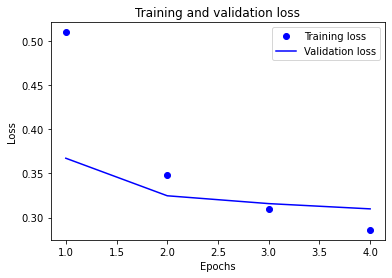

In [37]:
history_dict = history.history
import matplotlib.pyplot as plt

acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)

# "bo"는 "파란색 점"입니다
plt.plot(epochs, loss, 'bo', label='Training loss')
# b는 "파란 실선"입니다
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

Flatten도 Dropout 효과를 갖고 있다고 나왔다. 

## 결론

이번 감성분석을 통해서 RNN 모델을 수없이 만들었다 지웠다했다. 그러면서 확실하게 RNN을 알지는 못하지만 다양한 실험이 나에게 RNN 성능 향상에 어떠한 것이 필요한지 알려주었다.    
특히 cn231n에 나오는 다양한 정규화 기법을 쓰면서 했는데 이를 생각해냈다는 점에서 내가 발전해나가고 있음을 깨달았다.